<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.-Линейная-регрессия" data-toc-modified-id="1.-Линейная-регрессия-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>1. Линейная регрессия</a></span></li><li><span><a href="#2.-Random-Forest" data-toc-modified-id="2.-Random-Forest-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>2. Random Forest</a></span></li><li><span><a href="#3.-CatBoost" data-toc-modified-id="3.-CatBoost-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>3. CatBoost</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

Загрузим данные

In [2]:
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head

<bound method NDFrame.head of                   datetime  num_orders
0      2018-03-01 00:00:00           9
1      2018-03-01 00:10:00          14
2      2018-03-01 00:20:00          28
3      2018-03-01 00:30:00          20
4      2018-03-01 00:40:00          32
...                    ...         ...
26491  2018-08-31 23:10:00          32
26492  2018-08-31 23:20:00          24
26493  2018-08-31 23:30:00          27
26494  2018-08-31 23:40:00          39
26495  2018-08-31 23:50:00          53

[26496 rows x 2 columns]>

Посмотрим распределение количества заказов в выборке

<AxesSubplot:>

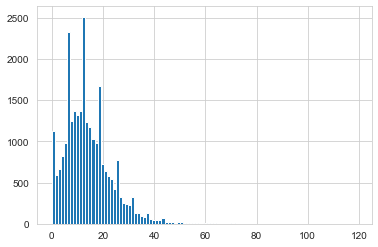

In [5]:
df['num_orders'].hist(bins=100)

Распределение кол-ва заказов похоже на распределение Пуассона. Правда есть немного странные пики.

Поменяем тип дат в datetime и сделаем этот столбец индексом

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [8]:
df.set_index('datetime',inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
df.index.is_monotonic

True

Даты индексы расположены в хронолигическом порядке, сортировка не требуется

Сделаем resampling по одному часу

In [11]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

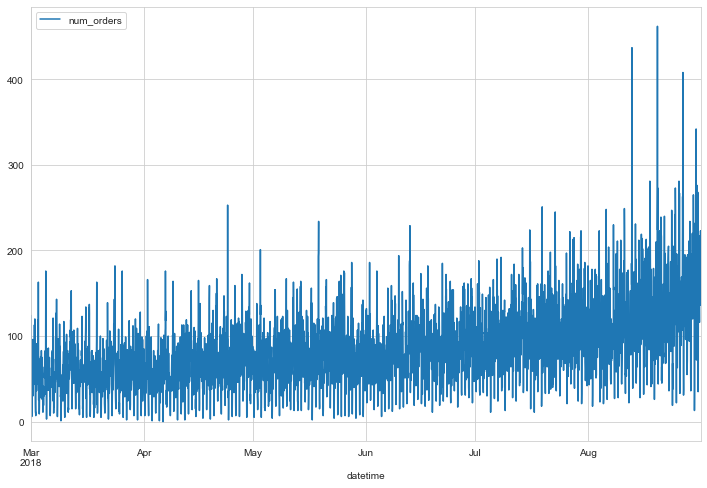

In [12]:
df.plot(figsize=(12,8))

<AxesSubplot:xlabel='datetime'>

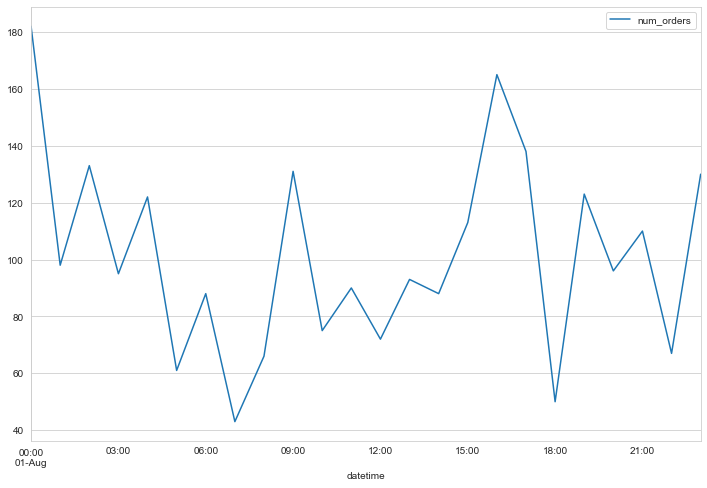

In [13]:
df['2018-08-01':'2018-08-01'].plot(figsize=(12,8))

## Анализ

Сделаем декомпозицию и посмотрим сезонность, тренд

In [14]:
decomposed = seasonal_decompose(df)

<AxesSubplot:xlabel='datetime'>

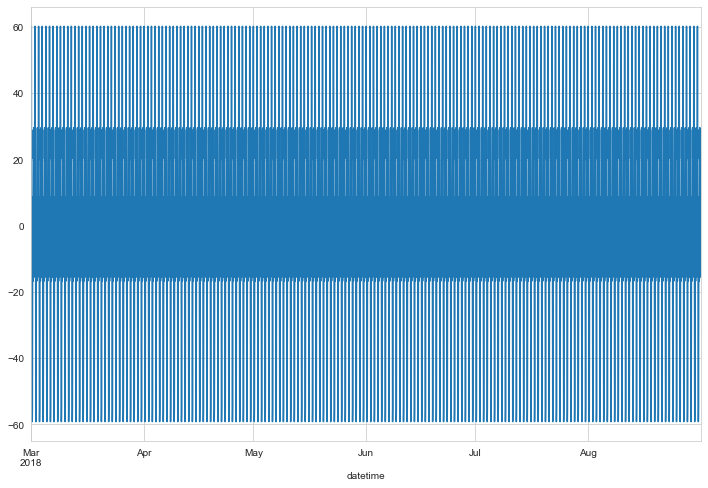

In [15]:
decomposed.seasonal.plot(figsize=(12,8))

Неинформативно, видимо сезонность наблюдается на меньшем интервале, попробуем неделю

<AxesSubplot:xlabel='datetime'>

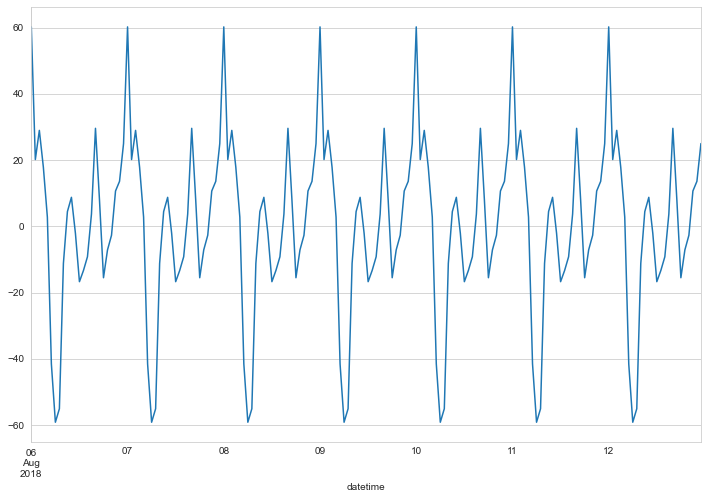

In [16]:
decomposed.seasonal['2018-08-06':'2018-08-12'].plot(figsize=(12,8))

<AxesSubplot:xlabel='datetime'>

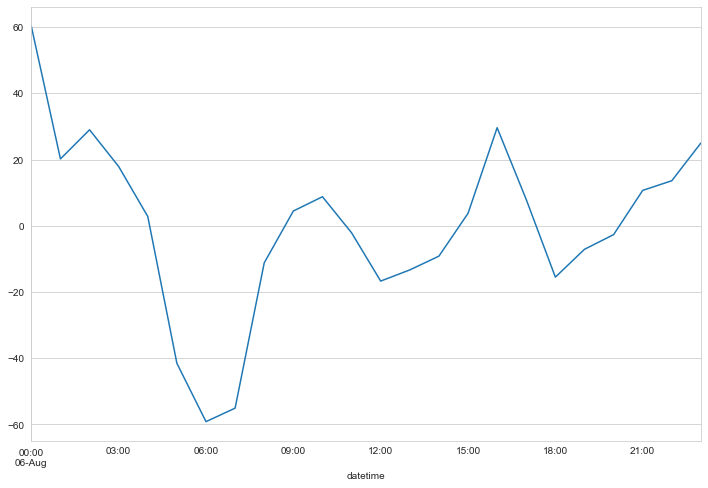

In [17]:
decomposed.seasonal['2018-08-06':'2018-08-06'].plot(figsize=(12,8))

Да, видна внутридневная "сезонность"

<AxesSubplot:xlabel='datetime'>

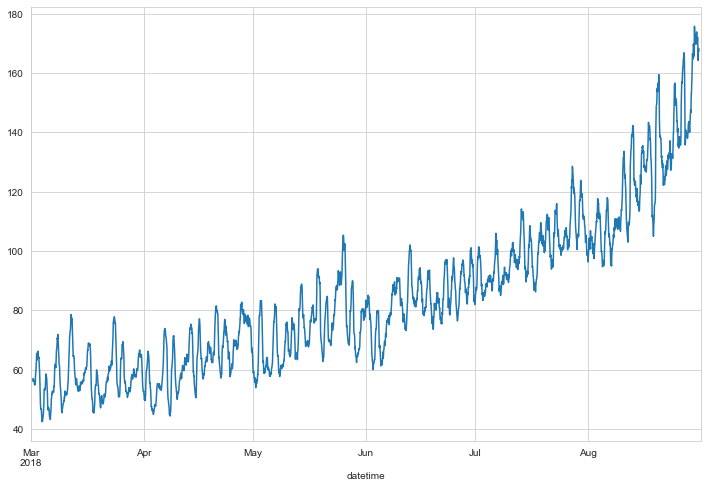

In [18]:
decomposed.trend.plot(figsize=(12,8))

<AxesSubplot:xlabel='datetime'>

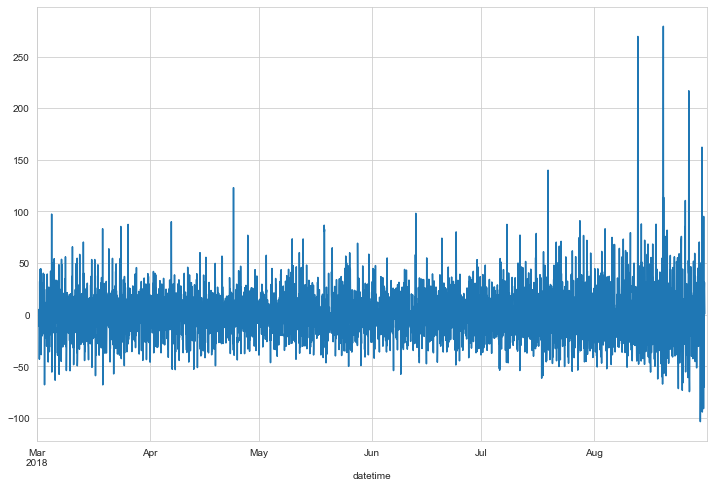

In [19]:
decomposed.resid.plot(figsize=(12,8))

Есть заметный тренд на рост количества заказов, также очевидна "сезонность" на уровне дня.

Добавим признаки в датасет.
Параметрами будут:
-Год
-Месяц
-День
-День недели
-Час
-Значения за предшествующий период
-Скользящее среднее сдвинутое на шаг (при расчете не участвует текущее значения кол-ва заказов)

In [21]:
def make_features(input_df, moving_avg_size_1, moving_avg_size_2):
    data = input_df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for i in range(1,25):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)

    data['lag_48'] = data['num_orders'].shift(48) #лаг в двое суток
    data['lag_72'] = data['num_orders'].shift(72) #лаг в трое суток
    data['lag_168'] = data['num_orders'].shift(168) #лаг в неделю

    data['move_avg_1'] = data['num_orders'].rolling(moving_avg_size_1).mean()
    data['move_avg_1'] = data['move_avg_1'].shift()

    data['move_avg_2'] = data['num_orders'].rolling(moving_avg_size_2).mean()
    data['move_avg_2'] = data['move_avg_2'].shift()

    return data


Вызовем функцию со следующими параметрами:
-скользящее среднее за 5 часов
-скользящее среднее за неделю

In [22]:
df_w_f = make_features(df,5,168)

In [23]:
df_w_f.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_48,lag_72,lag_168,move_avg_1,move_avg_2
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим NaN появившиеся в результате применения метода shift

In [24]:
df_w_f = df_w_f.dropna()

In [25]:
df_w_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4248 non-null   int64  
 1   year        4248 non-null   int64  
 2   month       4248 non-null   int64  
 3   day         4248 non-null   int64  
 4   dayofweek   4248 non-null   int64  
 5   hour        4248 non-null   int64  
 6   lag_1       4248 non-null   float64
 7   lag_2       4248 non-null   float64
 8   lag_3       4248 non-null   float64
 9   lag_4       4248 non-null   float64
 10  lag_5       4248 non-null   float64
 11  lag_6       4248 non-null   float64
 12  lag_7       4248 non-null   float64
 13  lag_8       4248 non-null   float64
 14  lag_9       4248 non-null   float64
 15  lag_10      4248 non-null   float64
 16  lag_11      4248 non-null   float64
 17  lag_12      4248 non-null   float64
 18  lag_13      4248 non-nul

Разобьем выборку на train и test. Размер тестовой выборки - 10% от исходного сета

In [26]:
train, test = train_test_split(df_w_f, test_size=0.1, shuffle=False)

In [27]:
x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [31]:
x_train.index.is_monotonic

True

In [32]:
x_test.index.is_monotonic

True

## Обучение

#### 1. Линейная регрессия

In [121]:
model_lg = LinearRegression()

In [122]:
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [123]:
t_split = tscv.split(x_train)

Посмотрим что получилось на примере одной из выборок train-valid

In [124]:
t_split_list = list(t_split)

In [125]:
t_split_list[4]

(array([   0,    1,    2, ..., 3183, 3184, 3185]),
 array([3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196,
        3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207,
        3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218,
        3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229,
        3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240,
        3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251,
        3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262,
        3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273,
        3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284,
        3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295,
        3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306,
        3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317,
        3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326,

In [126]:
scores_lg = cross_val_score(model_lg, x_train, y_train,scoring='neg_root_mean_squared_error',cv=tscv)

In [127]:
std = (scores_lg*(-1)).std()

In [128]:
mean = (scores_lg*(-1)).mean()

In [129]:
print(f"RMSE на кросс-валидации {mean:.2f} +/- {std:.2f}")

RMSE на кросс-валидации 22.49 +/- 3.01


Немного странно метрика падает с каждой новой итерацией кросс-валидации, видимо по ходу нашего временного отрезка данные становятся шумнее

Линейная регрессия дает неплохой результат, лучше чем целевое значение RMSE=48

#### 2. Random Forest

In [130]:
params = {
    "max_depth": [3,5,10,20],
    'n_estimators':[100,200,400,600]
}
model_rf = RandomForestRegressor()
model_grid = GridSearchCV(model_rf,
                             params,
                             cv=tscv,
                             n_jobs=-1,
                             refit=True,
                             scoring='neg_root_mean_squared_error'
                             )

model_grid.fit(x_train,y_train)





<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20],
                         'n_estimators': [100, 200, 400, 600]},
             scoring='neg_root_mean_squared_error')

In [131]:
mean = model_grid.cv_results_['mean_test_score'].max()

In [132]:
std = model_grid.cv_results_['std_test_score'][np.argmax(model_grid.cv_results_['mean_test_score'])]

In [133]:
print(f"RMSE на кросс-валидации {mean:.2f} +/- {std:.2f}")

RMSE на кросс-валидации -22.87 +/- 3.34


In [134]:
model_grid.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [135]:
model_grid.cv_results_

{'mean_fit_time': array([ 0.75568461,  1.47331419,  2.77211795,  4.15392947,  1.16937337,
         2.3436286 ,  4.05476928,  6.48488131,  1.96925335,  4.50272636,
         8.4827271 , 11.9350173 ,  2.69220004,  5.02826796,  8.85548153,
        12.32919478]),
 'std_fit_time': array([0.3051703 , 0.56802492, 1.23844838, 1.70903684, 0.66024753,
        0.80404039, 1.82982308, 3.16471407, 1.11395078, 2.09310682,
        3.90434967, 5.05764043, 1.35038055, 2.52687119, 4.16771633,
        5.68294574]),
 'mean_score_time': array([0.01056738, 0.01033688, 0.0160924 , 0.02157855, 0.00680246,
        0.0098568 , 0.022047  , 0.03020544, 0.01295528, 0.01991987,
        0.03498707, 0.04448261, 0.01139359, 0.02100401, 0.03769188,
        0.0566268 ]),
 'std_score_time': array([0.00983856, 0.00222746, 0.00294007, 0.00363049, 0.00323913,
        0.00080832, 0.00348379, 0.00289259, 0.00536261, 0.01008075,
        0.00724152, 0.00242121, 0.00153874, 0.00258255, 0.00230306,
        0.00548507]),
 'param_ma

In [136]:
model_rf = RandomForestRegressor(**search.best_params_,random_state=2022)

У RF результат почти такой же как и у линейной модели

#### 3. CatBoost

Создадим Pool

In [137]:
train_pool = Pool(data=x_train,
                  label=y_train
                 )

Выберем параметры

In [138]:
cb_params = {"iterations": 500,
             "depth": 8,
             "loss_function": "RMSE",
             "verbose": False}

Сделаем кросс-валидацию

In [139]:
scores = cv(train_pool,
            cb_params,
            type='TimeSeries',
            fold_count=5,
            plot="True",
            shuffle=False
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 23.92457876
bestIteration = 361

Training on fold [1/5]

bestTest = 21.4974545
bestIteration = 487

Training on fold [2/5]

bestTest = 20.85571496
bestIteration = 381

Training on fold [3/5]

bestTest = 22.53251834
bestIteration = 283

Training on fold [4/5]

bestTest = 31.0416036
bestIteration = 438



In [140]:
print(f"RMSE на кросс-валидации {scores.iloc[-1]['test-RMSE-mean']:.2f} +/- {scores.iloc[-1]['test-RMSE-std']:.2f}")

RMSE на кросс-валидации 24.07 +/- 4.09


Попробуем еще один сет параметров

In [141]:
cb_params = {"iterations": 1000,
             "depth": 6,
             "loss_function": "RMSE",
             'learning_rate': 0.05,
             "verbose": False}

In [142]:
scores = cv(train_pool,
            cb_params,
            type='TimeSeries',
            fold_count=5,
            plot="True",
            shuffle=False
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 20.47161606
bestIteration = 200

Training on fold [1/5]

bestTest = 20.41349053
bestIteration = 416

Training on fold [2/5]

bestTest = 20.85715339
bestIteration = 80

Training on fold [3/5]

bestTest = 21.70030601
bestIteration = 157

Training on fold [4/5]

bestTest = 29.59872166
bestIteration = 352



In [143]:
type(scores)

pandas.core.frame.DataFrame

In [144]:
print(f"RMSE на кросс-валидации {scores.iloc[999]['test-RMSE-mean']:.2f} +/- {scores.iloc[999]['test-RMSE-std']:.2f}")

RMSE на кросс-валидации 23.11 +/- 4.03


Все модели показали очень схожие результаты на кросс-валидации, а лучший результат как ни странно у простой линейной регрессии

Но заодно проверим модель на адекватность посчитав rmse константных моделей.

In [166]:
predict_const = y_train.shift()

In [167]:
y_train_const = y_train.drop(index=y_train.index[0], axis=0, inplace=False)

In [168]:
predict_const.drop(index=predict_const.index[0], axis=0, inplace=True)

In [169]:
predict_const.head()

datetime
2018-03-08 01:00:00    143.0
2018-03-08 02:00:00     78.0
2018-03-08 03:00:00     65.0
2018-03-08 04:00:00     68.0
2018-03-08 05:00:00     60.0
Freq: H, Name: num_orders, dtype: float64

In [170]:
y_train_const.head()

datetime
2018-03-08 01:00:00    78
2018-03-08 02:00:00    65
2018-03-08 03:00:00    68
2018-03-08 04:00:00    60
2018-03-08 05:00:00     6
Freq: H, Name: num_orders, dtype: int64

In [171]:
rmse = mean_squared_error(y_train_const,predict_const,squared=False)

In [172]:
print('RMSE константной модели:', '{:.2f}'.format(rmse))

RMSE константной модели: 36.49


Модели адекватны, значение метрики на валидации значительно лучше чем метрика константной модели

## Тестирование

In [153]:
model_lg.fit(x_train, y_train)

predict = model_lg.predict(x_test)
print('RMSE на тестовой выборке:', mean_squared_error(y_test, predict, squared=False))

RMSE на тестовой выборке: 35.88291755718595


Результат значительно хуже чем на валидации, но полагаю, он обусловлен случайными резкими большими пиками в августе 2018 (именно в этом периоде у нас тестовая выборка находится), которые модель не могла предсказать. Тем не менее RMSE попадает в целевую категорию <48
См ниже

<AxesSubplot:xlabel='datetime'>

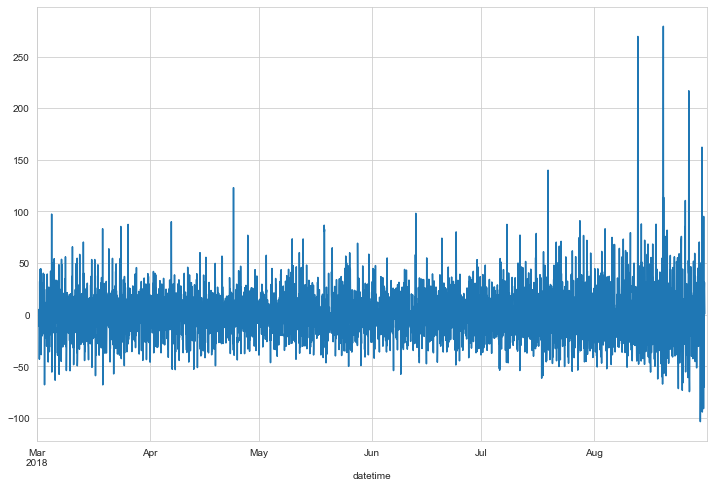

In [154]:
decomposed.resid.plot(figsize=(12,8))

In [158]:
feature_importance = pd.DataFrame({'name':model_lg.feature_names_in_,'w':model_lg.coef_})


In [161]:
feature_importance.sort_values(by='w', ascending=False)

,name,w
1,month,3.153542e+00
31,lag_168,4.117085e-01
4,hour,2.814888e-01
2,day,2.083819e-01
29,lag_48,1.885798e-01
30,lag_72,1.361208e-01
28,lag_24,9.967844e-02
5,lag_1,9.813934e-02
6,lag_2,5.416321e-02
11,lag_7,4.986243e-02


Получается наибольший вес имеет признак месяца, затем идет значение за неделю назад (лаг 168)

In [162]:
results_df = pd.DataFrame({'True':y_test,'Predictions':predict},index=test.index)

<AxesSubplot:xlabel='datetime'>

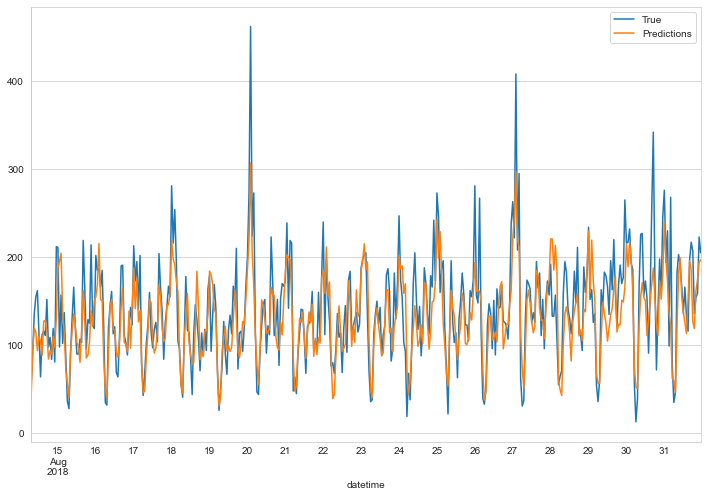

In [163]:
results_df.plot(figsize=(12,8))

In [164]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2018-08-14 07:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   True         425 non-null    int64  
 1   Predictions  425 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 10.0 KB


<AxesSubplot:xlabel='datetime'>

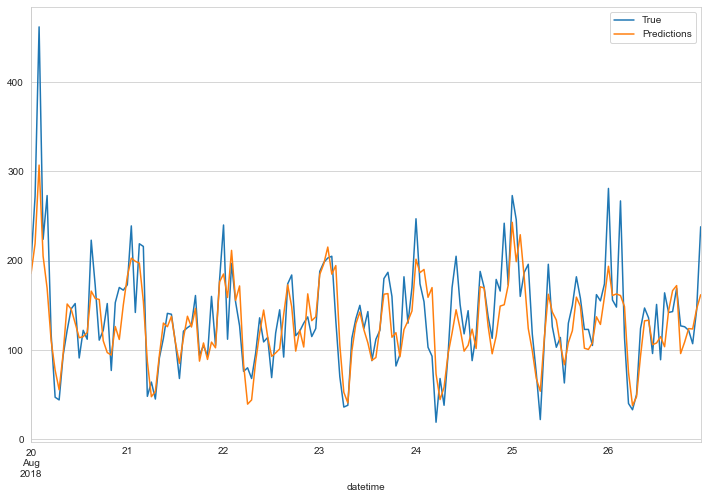

In [165]:
results_df['2018-08-20':'2018-08-26'].plot(figsize=(12,8))

Алгоритм достаточно точно предсказывает все внутридневные смены направлений, но модель не совсем точна в предсказании пиковых значений, которые вероятно подвержены случайному фактору.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48